# Visualising MCC Exploration

In [203]:
import copy

import torch
from tqdm import tqdm
from omegaconf import DictConfig
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium.wrappers.autoreset import AutoResetWrapper 

from curiosity.experience import Transition
from curiosity.policy import ColoredNoisePolicy
from curiosity.experience.memory import ReplayBuffer
from curiosity.experience.util import build_replay_buffer, build_collector
from curiosity.util.util import build_actor, build_critic, build_env, global_seed, build_intrinsic, build_rl

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COLLECTION_STEPS = 10000


cfg = DictConfig({
    "seed": 0,
    "env": {
        "name": "MountainCarContinuous-v0",
    },
    "memory": {
        "type": "experience_replay"
    },
    "train": {
        "initial_collection_size": 1000,
        "total_frames": COLLECTION_STEPS,
        "minibatch_size": 128   
    },
    "algorithm": {
        "type": "ddpg",
        "gamma": 0.99,
        "tau": 0.005,
        "lr": 0.001,
        "update_frequency": 1,
        "clip_grad_norm": 1,
        "actor": {
            "features": 128
        },
        "critic": {
            "features": 128
        }
    },
    "intrinsic": {
        "type": "rnd",
        "encoding_size": 32,
        "lr": 0.0003,
        "int_coef": 1, 
        "ext_coef": 2,
        "obs_normalisation": True,
        "reward_normalisation": True,
        "normalised_obs_clip": 5
    },
    "noise": {
        "scale": 0.1,
        "beta": 0 
    }
})

def reset():
    env = AutoResetWrapper(gym.make(
        cfg.env.name,
        render_mode="rgb_array",
        max_episode_steps=300
        ))
    env.reset()

    rng = global_seed(cfg.seed, env)

    ddpg = build_rl(env, cfg.algorithm, device=DEVICE)
    policy = ColoredNoisePolicy(
        ddpg.actor,
        env.action_space,
        env.spec.max_episode_steps,
        rng=rng,
        device=DEVICE,
        **cfg.noise
    )


    memory = build_replay_buffer(env,capacity=COLLECTION_STEPS, device=DEVICE)
    collector = build_collector(policy, env, memory, device=DEVICE)
    intrinsic = build_intrinsic(env, cfg.intrinsic, device=DEVICE)

    return env, rng, ddpg, policy, memory, collector, intrinsic

def visualise_memory_mcc(env, *memories: ReplayBuffer):
    
    fig, ax = plt.subplots()
    ax.set_title("State Space Coverage")
    ax.set_xlim(env.observation_space.low[0], env.observation_space.high[0])
    ax.set_ylim(env.observation_space.low[1], env.observation_space.high[1])

    for memory, name in memories:
        batch = Transition(*memory.storage)
        s = batch.s_0.cpu().numpy()
        ax.scatter(s[:, 0], s[:, 1], s=2, label=name)
    ax.legend()

In [159]:
# Extrinsic Only
env, rng, ddpg, policy, memory, collector, intrinsic = reset()
collector.early_start(cfg.train.initial_collection_size)
batch, aux = memory.sample(cfg.train.initial_collection_size)
intrinsic.initialise(Transition(*batch), aux)

for step in tqdm(range(1, cfg.train.total_frames+1)):
    collector.collect(n=1)
    batch, aux = memory.sample(cfg.train.minibatch_size)
    batch = Transition(*batch)

    r_t, r_e, r_i = intrinsic.reward(batch)
    intrinsic.update(batch, aux, step=step)

    batch = Transition(batch.s_0, batch.a, r_e, batch.s_1, batch.d)
    ddpg.update(batch, aux, step=step)

extrinsic_memory = memory

100%|██████████| 10000/10000 [00:33<00:00, 296.74it/s]


In [204]:
# Intrinsic Only
env, rng, ddpg, policy, memory, collector, intrinsic = reset()
collector.early_start(cfg.train.initial_collection_size)
batch, aux = memory.sample(cfg.train.initial_collection_size)
intrinsic.initialise(Transition(*batch), aux)

for step in tqdm(range(1, cfg.train.total_frames+1)):
    collector.collect(n=1)
    batch, aux = memory.sample(cfg.train.minibatch_size)
    batch = Transition(*batch)

    r_t, r_e, r_i = intrinsic.reward(batch)
    intrinsic.update(batch, aux, step=step)

    batch = Transition(batch.s_0, batch.a, r_i, batch.s_1, batch.d)
    ddpg.update(batch, aux, step=step)

intrinsic_memory = memory

100%|██████████| 10000/10000 [00:30<00:00, 331.67it/s]


In [205]:
# Together Only
env, rng, ddpg, policy, memory, collector, intrinsic = reset()
collector.early_start(cfg.train.initial_collection_size)
batch, aux = memory.sample(cfg.train.initial_collection_size)
intrinsic.initialise(Transition(*batch), aux)

for step in tqdm(range(1, cfg.train.total_frames+1)):
    collector.collect(n=1)
    batch, aux = memory.sample(cfg.train.minibatch_size)
    batch = Transition(*batch)

    r_t, r_e, r_i = intrinsic.reward(batch)
    intrinsic.update(batch, aux, step=step)

    batch = Transition(batch.s_0, batch.a, r_t, batch.s_1, batch.d)
    ddpg.update(batch, aux, step=step)

sum_memory = memory

100%|██████████| 10000/10000 [00:29<00:00, 337.62it/s]


In [206]:
# Teleportation
env, rng, ddpg, policy, memory, collector, intrinsic = reset()

trajectory = torch.zeros((env.spec.max_episode_steps, *env.observation_space.shape), device=DEVICE)
trajectory_index = 0
resets = [None for _ in range(env.spec.max_episode_steps)]

print(env.spec.max_episode_steps)

collector.early_start(cfg.train.initial_collection_size)
batch, aux = memory.sample(cfg.train.initial_collection_size)
intrinsic.initialise(Transition(*batch), aux)

collector.env.reset()
state = copy.deepcopy(collector.env)

np_rng = np.random.default_rng(cfg.seed)


for step in tqdm(range(1, cfg.train.total_frames+1)):    
    obs, action, reward, n_obs, terminated, truncated = collector.collect(n=1)[-1]
    # Update trajectory
    resets[trajectory_index] = state
    trajectory[trajectory_index] = torch.from_numpy(obs).to(DEVICE)
    state = copy.deepcopy(collector.env)
    trajectory_index += 1
    # Manage Teleportation
    if truncated or terminated:
        # Calculate Value
        for i in range(10):
            trajectory[i] = torch.tensor(collector.env.reset()[0], device=DEVICE)
            resets[i] = copy.deepcopy(collector.env)

        t = trajectory[:trajectory_index]
        target_action = ddpg.actor.target(t)
        V = ddpg.critic.target(torch.cat((t, target_action), 1))
        teleport_index = torch.argmax(V).item()
        # Teleport
        collector.env = resets[teleport_index]
        collector.obs = trajectory[teleport_index].cpu().numpy()
        collector.env.np_random = np.random.default_rng(np_rng.integers(65536))
        print(f"===== {trajectory_index} {teleport_index} {truncated} {terminated} ====")
        if teleport_index < 10:
            teleport_index = 0
        trajectory_index = teleport_index
        state = copy.deepcopy(collector.env)
        

    batch, aux = memory.sample(cfg.train.minibatch_size)
    batch = Transition(*batch)

    r_t, r_e, r_i = intrinsic.reward(batch)
    intrinsic.update(batch, aux, step=step)

    batch = Transition(batch.s_0, batch.a, r_i, batch.s_1, batch.d)
    ddpg.update(batch, aux, step=step)

teleport_memory = memory

300


100%|██████████| 10000/10000 [00:35<00:00, 279.52it/s]


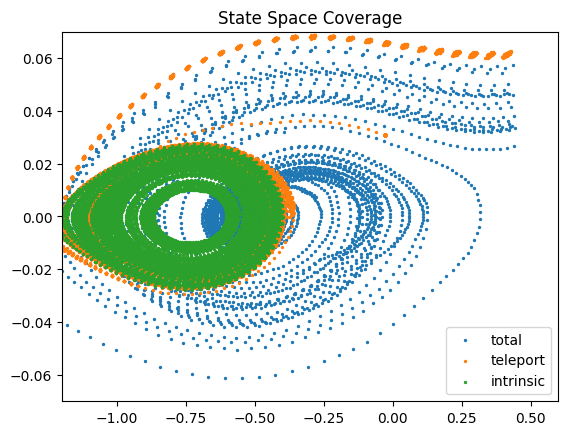

In [209]:
visualise_memory_mcc(
    env,
    #(extrinsic_memory, "extrinsic"),
    (sum_memory, "total"),
    (teleport_memory, "teleport"),
    (intrinsic_memory, "intrinsic"),
)   

In [176]:
from IPython.display import clear_output

obs, _ = env.reset()
terminated = False
truncated = False

with torch.no_grad():
    while not terminated and not truncated:
        action = policy(obs).cpu()
        obs, reward, terminated, truncated, _ = env.step(action)
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

KeyboardInterrupt: 